In [1]:
%matplotlib inline

## Load the block of simulation data

In [2]:
from load_tng_parametric_scatter_data import load_tng_mah_data
res = load_tng_mah_data()
halo_ids, log_mah_500c, log_mah_200m, log_mah_mvir, tng_t, log_mah_fit_min = res
n_halos = halo_ids.size

## Load the best-fit parameters

In [3]:
import os
import h5py
from collections import OrderedDict

drn = "/Users/aphearin/work/random/0112/FIT_DATA"

fit_data_200m = OrderedDict()
with h5py.File(os.path.join(drn, "M200mean_Msun.h5"), 'r') as hdf:
    for key in hdf.keys():
        fit_data_200m[key] = hdf[key][...]

fit_data_500c = OrderedDict()
with h5py.File(os.path.join(drn, "M500crit_Msun.h5"), 'r') as hdf:
    for key in hdf.keys():
        fit_data_500c[key] = hdf[key][...]

fit_data_vir = OrderedDict()
with h5py.File(os.path.join(drn, "Mvir_Msun.h5"), 'r') as hdf:
    for key in hdf.keys():
        fit_data_vir[key] = hdf[key][...]

## Calculate the best-fit smooth MAHs

In [4]:
from diffmah.individual_halo_assembly import calc_halo_history

dmhdt, log_mah = calc_halo_history(tng_t, tng_t[-1], fit_data_vir['logmp_fit'], 
                  10**fit_data_vir['mah_logtc'], fit_data_vir['early_index'], fit_data_vir['late_index'])
fit_data_vir['log_mah'] = log_mah

dmhdt, log_mah = calc_halo_history(tng_t, tng_t[-1], fit_data_500c['logmp_fit'], 
                  10**fit_data_500c['mah_logtc'], fit_data_500c['early_index'], fit_data_500c['late_index'])
fit_data_500c['log_mah'] = log_mah

dmhdt, log_mah = calc_halo_history(tng_t, tng_t[-1], fit_data_200m['logmp_fit'], 
                  10**fit_data_200m['mah_logtc'], fit_data_200m['early_index'], fit_data_200m['late_index'])
fit_data_200m['log_mah'] = log_mah

## Plot a randomly selected halo

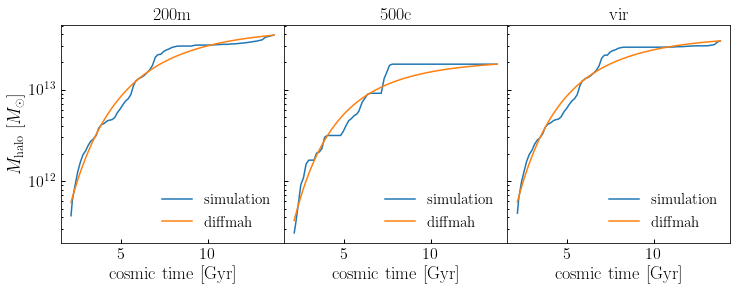

In [5]:
rng = np.random.RandomState(999)
ih = rng.randint(0, n_halos)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharex=True, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0)

for ax in ax0, ax1, ax2:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
    yscale = ax.set_yscale('log')
ylabel = ax0.set_ylabel(r'$M_{\rm halo}\ [M_{\odot}]$')
title = ax0.set_title(r'${\rm 200m}$')
title = ax1.set_title(r'${\rm 500c}$')
title = ax2.set_title(r'${\rm vir}$')

__=ax0.plot(tng_t, 10**log_mah_200m[ih, :], label=r'${\rm simulation}$')
__=ax0.plot(tng_t, 10**fit_data_200m['log_mah'][ih, :], label=r'${\rm diffmah}$')
__=ax1.plot(tng_t, 10**log_mah_500c[ih, :], label=r'${\rm simulation}$')
__=ax1.plot(tng_t, 10**fit_data_500c['log_mah'][ih, :], label=r'${\rm diffmah}$')
__=ax2.plot(tng_t, 10**log_mah_mvir[ih, :], label=r'${\rm simulation}$')
__=ax2.plot(tng_t, 10**fit_data_vir['log_mah'][ih, :], label=r'${\rm diffmah}$')

for ax in ax0, ax1, ax2:
    leg = ax.legend()
fig.savefig('example_tng_fit.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

## Calculate fitting residuals

In [6]:
from scipy.stats.mstats import trimmed_std, trimmed_mean


def measure_fitting_residuals(tarr, log_mah_sim, log_mah_fit, lgm_min, dlgm_min, pcut=0.01):
    assert tarr.size == log_mah_sim.shape[1], "shape mismatch between log_mah and tarr"

    nh, nt = log_mah_sim.shape
    avg_error = np.zeros(nt)
    std_error = np.zeros(nt)

    gen = zip(range(nt), tarr)
    for i, t in gen:
        log_mahs_at_t = log_mah_sim[:, i]
        log_mah_errs_at_t = log_mah_fit[:, i] - log_mahs_at_t

        low_mass_msk = log_mahs_at_t > lgm_min
        dlgm_msk = log_mahs_at_t > log_mah_sim[:, -1] - dlgm_min
        msk = low_mass_msk & dlgm_msk

        if msk.sum() >= 10:
            avg_error[i] = trimmed_mean(log_mah_errs_at_t[msk], limits=(pcut, pcut))
            std_error[i] = trimmed_std(log_mah_errs_at_t[msk], limits=(pcut, pcut))
    return avg_error, std_error


In [7]:
mu_200m, std_200m = measure_fitting_residuals(tng_t, log_mah_200m, fit_data_200m['log_mah'], 10, 2.5)
mu_500c, std_500c = measure_fitting_residuals(tng_t, log_mah_500c, fit_data_500c['log_mah'], 10, 2.5)
mu_mvir, std_mvir = measure_fitting_residuals(tng_t, log_mah_mvir, fit_data_vir['log_mah'], 10, 2.5)

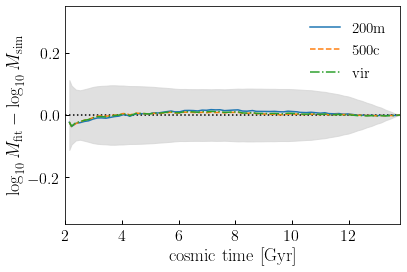

In [8]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(-0.35, 0.35)
xlim = ax.set_xlim(2, 13.8)
__=ax.plot(np.linspace(0, 20, 5000), np.zeros(5000), ':', color='k')

__=ax.plot(tng_t, mu_200m, label=r'${\rm 200m}$')
__=ax.plot(tng_t, mu_500c, '--', label=r'${\rm 500c}$')
__=ax.plot(tng_t, mu_mvir, '-.', label=r'${\rm vir}$')
leg = ax.legend()

__=ax.fill_between(tng_t, -std_mvir, std_mvir, color='lightgray', alpha=0.7)

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm fit} - \log_{10}M_{\rm sim}$')
fig.savefig('tng_fit_residuals.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)